In [1]:
import gzip
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
example = readCSV("train_Interactions.csv.gz")
print(next(example))
del example

['u79354815', 'b14275065', '4']


# Question 9

In [4]:
### Ratings Prediction

train_size = 150000
val_size   = 10000
data       = [line for line in readCSV("train_Interactions.csv.gz")]
train      = data[:train_size]
val        = data[train_size:]

allRatings = []
userBookRatings = defaultdict(lambda: defaultdict(float))
userRatings = defaultdict(list)
userBooks   = defaultdict(set)
bookUsers   = defaultdict(set)

for user, book, rating in train:
    rating = int(rating)
    allRatings.append(rating)
    userRatings[user].append(rating)
    userBookRatings[user][book] = rating
    userBooks[user].add(book)
    bookUsers[book].add(user)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for user in userRatings:
    userAverage[user] = sum(userRatings[user]) / len(userRatings[user])

In [5]:
# Coordinate Descent

def coordinate_descent(lambda_opt = 1, iterations = 100):

    alpha_sum, bu_sum, bb_sum = 0, 0, 0

    train_len = len(train)
    bu = defaultdict(lambda: 1)
    bb = defaultdict(lambda: 1)

    for descent in range(iterations):
        alpha_sum = 0
        for user, book, _ in train:
            alpha_sum += userBookRatings[user][book] - (bu[user] + bb[book])
        alpha = alpha_sum / train_len

        for user in userRatings:
            bu_sum = 0
            for book in userBooks[user]:
                bu_sum += userBookRatings[user][book] - (alpha + bb[book])
            bu[user] = bu_sum / (lambda_opt + len(userBooks[user]))

        for book in bookUsers:
            bb_sum = 0
            for user in bookUsers[book]:
                bb_sum += userBookRatings[user][book] - (alpha + bu[user])
            bb[book] = bb_sum / (lambda_opt + len(bookUsers[book]))
            
    return alpha, bu, bb

alpha, bu, bb = coordinate_descent(lambda_opt = 1)

In [6]:
rating_labels = []
diff = 0
for user, book, rating in val:
    user_rating = alpha + bu[user] + bb[book]
    diff += (user_rating - int(rating)) ** 2

MSE = diff / len(val)
print(MSE)

1.1090811196426422


# Question 10

# TODO

# Question 11

In [7]:
lambda_values = np.logspace(-1, 1.5, num = 20)
print(lambda_values)

[ 0.1         0.1159051   0.13433993  0.15570684  0.18047218  0.20917647
  0.2424462   0.28100752  0.32570207  0.37750532  0.43754794  0.5071404
  0.58780161  0.68129207  0.78965229  0.91524731  1.06081836  1.22954263
  1.42510267  1.65176674  1.91448198  2.21898234  2.57191381  2.9809794
  3.45510729  4.00464573  4.64158883  5.3798384   6.23550734  7.22727132
  8.3767764   9.70911147 11.25335583 13.04321387 15.11775071 17.5222448
 20.30917621 23.53937198 27.28333376 31.6227766 ]


In [8]:
MSEs = []
loop_count = 0
for lambda_opt in lambda_values:
    loop_count += 1; print(loop_count, end = ', ')
    alpha, bu, bb = coordinate_descent(lambda_opt, iterations = 20)
    rating_labels = []
    diff = 0
    for user, book, rating in val:
        user_rating = alpha + bu[user] + bb[book]
        diff += (user_rating - int(rating)) ** 2
    MSE = diff / len(val)
    MSEs.append(MSE)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

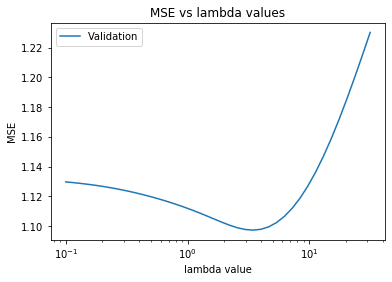

In [9]:
plt.plot(lambda_values, MSEs, label='Validation')
plt.ylabel('MSE')
plt.xlabel('lambda value'), plt.xscale('log')
plt.title('MSE vs lambda values')
plt.legend()
plt.show()

In [10]:
indx = MSEs.index(min(MSEs))
print('\nLambda for lowest MSE is:', lambda_values[indx])
print('\nBest MSE is:', MSEs[indx])


Lambda for lowest MSE is: 3.455107294592218

Best MSE is: 1.097197809965573


In [11]:
alpha, bu, bb = coordinate_descent(2.8, iterations = 100)

In [12]:
with open("predictions_Rating.txt", 'w') as predictions:
    for l in open("pairs_Rating.txt"):
        if l.startswith("userID"):
            #header
            predictions.write(l)
            continue
        user, book = l.strip().split('-')
        user_rating = alpha + bu[user] + bb[book]
        predictions.write(user + '-' + book + ',' + str(user_rating) + '\n')